In [57]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset,DataLoader 
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


In [58]:
#Global Constants
BASIC_PATH = r'./data/'
TRAIN_PATH = os.path.join(BASIC_PATH,'training.csv')
TEST_PATH = os.path.join(BASIC_PATH,'test.csv')

In [59]:
#Load the data
train_data = pd.read_csv(TRAIN_PATH)
test_data = pd.read_csv(TEST_PATH)
print(train_data.columns)
print(test_data.columns)

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y', 'Image'],
      dtype='object')
Index(['ImageId', 'Image'], dtype='object')


In [60]:
train_data.head(3).T

,0,1,2
left_eye_center_x,66.033564,64.332936,65.057053
left_eye_center_y,39.002274,34.970077,34.909642
right_eye_center_x,30.227008,29.949277,30.903789
right_eye_center_y,36.421678,33.448715,34.909642
left_eye_inner_corner_x,59.582075,58.85617,59.412
left_eye_inner_corner_y,39.647423,35.274349,36.320968
left_eye_outer_corner_x,73.130346,70.722723,70.984421
left_eye_outer_corner_y,39.969997,36.187166,36.320968
right_eye_inner_corner_x,36.356571,36.034723,37.678105
right_eye_inner_corner_y,37.389402,34.361532,36.320968


In [61]:
train_data.fillna(method='ffill', inplace=True)
train_data.isnull().any().value_counts()


False    31
dtype: int64

In [62]:
IMG_SIZE = 96  # image size 96 x 96 pixels


def show_keypoints(image, keypoints):
    '''
    Show image with keypoints
    Args:
        image (array-like or PIL image): The image data. (M, N)
        keypoints (array-like): The keypoits data. (N, 2)
    '''
    plt.imshow(image, cmap='gray')
    if len(keypoints):
        plt.scatter(keypoints[:, 0], keypoints[:, 1], s=24, marker='.', c='r')

def show_images(df, indxs, ncols=5, figsize=(15,10), with_keypoints=True):
    '''
    Show images with keypoints in grids
    Args:
        df (DataFrame): data (M x N)
        idxs (iterators): list, Range, Indexes
        ncols (integer): number of columns (images by rows)
        figsize (float, float): width, height in inches
        with_keypoints (boolean): True if show image with keypoints
    '''
    plt.figure(figsize=figsize)
    nrows = len(indxs) // ncols + 1
    for i, idx in enumerate(indxs):
        image = np.fromstring(df.loc[idx, 'Image'], sep=' ').astype(np.float32)\
                .reshape(-1, IMG_SIZE)
        if with_keypoints:
            keypoints = df.loc[idx].drop('Image').values.astype(np.float32)\
                        .reshape(-1, 2)
        else:
            keypoints = []
        plt.subplot(nrows, ncols, i + 1)
        plt.title(f'Sample #{idx}')
        plt.axis('off')                 #关闭坐标轴
        plt.tight_layout()              # tight_layout会自动调整子图参数，使之填充整个图像区域
        show_keypoints(image, keypoints)
    plt.show()


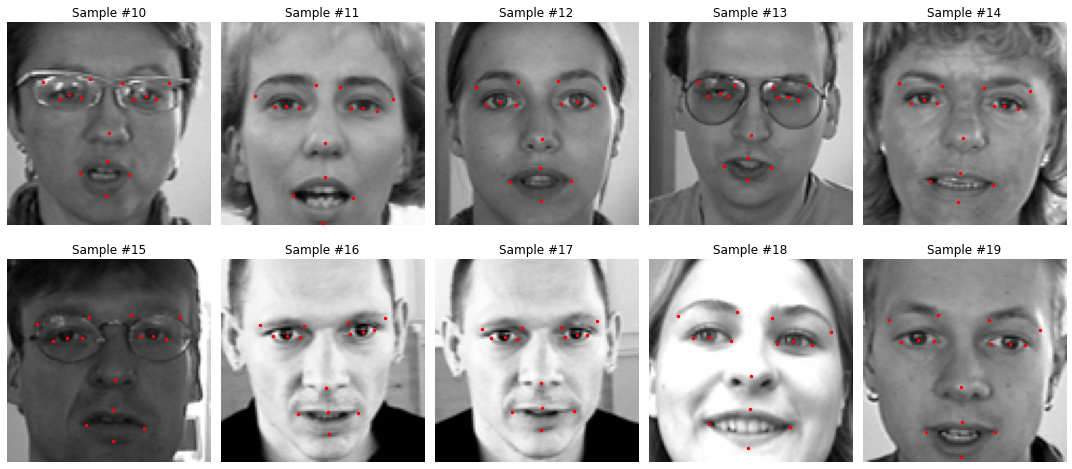

In [63]:
show_images(train_data, range(10,20))

In [64]:
class FaceKeypointsDataset(Dataset):
    '''Face Keypoints Dataset'''

    def __init__(self, dataframe, train=True, transform=None):
        '''
        Args:
            dataframe (DataFrame): data in pandas dataframe format.
            train (Boolean) : True for train data with keypoints, default is True
            transform (callable, optional): Optional transform to be applied on 
            sample
        '''
        self.dataframe = dataframe
        self.train = train
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image = np.fromstring(self.dataframe.iloc[idx, -1], sep=' ')\
            .astype(np.float32).reshape(-1, IMG_SIZE)
        if self.train:
            keypoints = self.dataframe.iloc[idx, :-1].values.astype(np.float32)
        else:
            keypoints = None
        sample = {'image': image, 'keypoints': keypoints}
        if self.transform:
            sample = self.transform(sample)
        return sample


class Normalize(object):
    '''Normalize input images'''
    def __call__(self, sample):
        image, keypoints = sample['image'], sample['keypoints']
        return {'image': image / 255., # scale to [0, 1]
                'keypoints': keypoints}
                
        
class ToTensor(object):
    '''Convert ndarrays in sample to Tensors.'''
    def __call__(self, sample):
        image, keypoints = sample['image'], sample['keypoints']
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.reshape(1, IMG_SIZE, IMG_SIZE)
        image = torch.from_numpy(image)
        if keypoints is not None:
            keypoints = torch.from_numpy(keypoints)
            return {'image': image, 'keypoints': keypoints}
        else:
            return {'image': image}

In [65]:
from torch.utils.data.sampler import SubsetRandomSampler

def prepare_train_valid_loaders(trainset,valid_size = 0.2,batch_size = 128):

    # obtain training indices that will be used for validation
    num_train = len(trainset)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size*num_train))
    train_idx, valid_idx = indices[split:], indices[:split]

    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    # prepare data loaders
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               sampler=train_sampler)
    valid_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               sampler=valid_sampler)

    return train_loader, valid_loader


In [66]:
from torchvision import transforms

# how many samples per batch to load
batch_size = 128
# percentage of training set to use as validation
valid_size = 0.2

# Define a transform to normalize the data
tsfm = transforms.Compose([Normalize(), ToTensor()])

# Load the training data and test data
trainset = FaceKeypointsDataset(train_data, transform=tsfm)
testset = FaceKeypointsDataset(test_data, train=False, transform=tsfm)

# prepare data loaders
train_loader, valid_loader = prepare_train_valid_loaders(trainset,
                                                         valid_size,
                                                         batch_size)

test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size)


In [67]:
#Model
class CNN(nn.Module):
    def __init__(self,outputs = 30):
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64*12*12, 1024)
        self.fc2 = nn.Linear(1024, outputs)
        self.dropout = nn.Dropout(0.3)

    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64*12*12)
        x = F.relu(self.fc1(self.dropout(x)))
        x = self.fc2(self.dropout(x))
        return x


In [68]:
#Train & Test
device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN(outputs = 30)
model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)


def train(train_loader,valid_loader,model,criterion,optimizer,n_epochs = 50,saved_model = 'cv_model.pt'):
    valid_loss_min = np.Inf
    train_losses = []
    valid_losses = []

    for epoch in range(n_epochs):

        train_loss = 0.0
        valid_loss = 0.0

        #training
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()

            output = model(batch['image'].to(device))
            loss = criterion(output,batch['keypoints'].to(device))
            loss.backward()
            optimizer.step()

            train_loss += loss.item()*batch['image'].size(0)
        
        #validating
        model.eval()
        for batch in valid_loader:
            output = model(batch['image'].to(device))
            loss = criterion(output, batch['keypoints'].to(device))
            valid_loss += loss.item()*batch['image'].size(0)

        train_loss = np.sqrt(train_loss/len(train_loader.sampler.indices))
        valid_loss = np.sqrt(valid_loss/len(valid_loader.sampler.indices))

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'
              .format(epoch+1, train_loss, valid_loss))

        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'
                  .format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), saved_model)
            valid_loss_min = valid_loss

    return train_losses, valid_losses
    


In [ ]:
train(train_loader, valid_loader, model, criterion,  optimizer, n_epochs=50, saved_model='aug_cnn.pt')

In [70]:

def predict(data_loader, model):
    '''
    Predict keypoints
    Args:
        data_loader (DataLoader): DataLoader for Dataset
        model (nn.Module): trained model for prediction.
    Return:
        predictions (array-like): keypoints in float (no. of images x keypoints).
    '''

    model.eval()  # prep model for evaluation

    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(batch['image'].to(device)).cpu().numpy()
            if i == 0:
                predictions = output
            else:
                predictions = np.vstack((predictions, output))

    return predictions

def view_pred_df(columns, test_df, predictions, image_ids=range(1,6)):
    '''
    Display predicted keypoints
    Args:
        columns (array-like): column names
        test_df (DataFrame): dataframe with ImageId and Image columns
        predictions (array-like): keypoints in float (no. of images x keypoints)
        image_id (array-like): list or range of ImageIds begin at 1
    '''
    pred_df = pd.DataFrame(predictions, columns=columns)
    pred_df = pd.concat([pred_df, test_df], axis=1)
    pred_df = pred_df.set_index('ImageId')
    show_images(pred_df, image_ids)  # ImageId as index begin at 1


def create_submission(predictions, pred_file='data/preds.csv', sub_file='data/submission.csv', columns=None):
    '''
    Create csv file for submission from predictions
    Args:
        predictions (array-like): prediction (no. fo images x 30 keypoints)
        pred_file (string): file path for prediction csv file
        sub_file (string): file path for submission csv file
        columns (dict): provided column names for submission file
    '''
    lookup = pd.read_csv('data/IdLookupTable.csv')
    if columns == None:
        columns = train_data.columns[:-1]
    preds = pd.DataFrame(predictions,
                         index=np.arange(1, len(predictions)+1),
                         columns=columns)
    preds.to_csv(pred_file)
    locations = [preds.loc[image_id, feature_name]
                 for image_id, feature_name
                 in lookup[['ImageId', 'FeatureName']].values]
    locations = [location if location <
                 IMG_SIZE else IMG_SIZE for location in locations]
    lookup.Location = pd.Series(locations)
    lookup[['RowId', 'Location']].to_csv(sub_file, index=False)


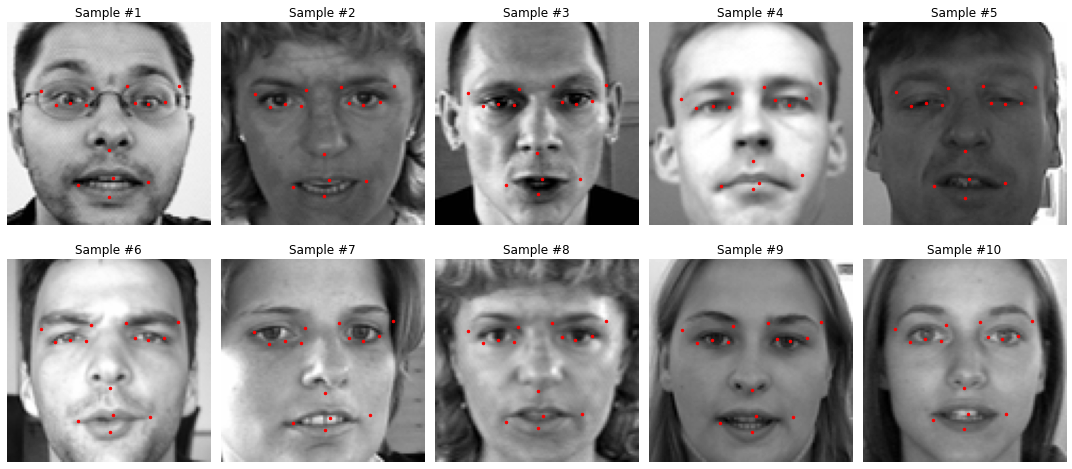

In [71]:
#Predict
model.load_state_dict(torch.load('aug_cnn.pt'))
predictions = predict(test_loader,model)
create_submission(predictions,
                  pred_file='data/aug_cnn_preds.csv',
                  sub_file='data/aug_cnn_submission.csv')
columns = train_data.drop('Image', axis=1).columns
view_pred_df(columns, test_data, predictions,range(1,11))
